In [1]:
import numpy as np
import itertools as it
import matplotlib.pyplot as plt
import pickle
import qutip as qtp
from operator import mul

from bi_PE_polytope import PE_analysis
from bi_lib import *

In [2]:
CHSH_ineq = CHSH_ineqs[0].copy()

def genDistCHSH(w):
    '''
    Generate a correlation which is a mixture of the optimal CHSH correlations
    and white noise: 
       P(a,b,x,y) = (1-w)*P_CHSH(a,b,x,y) + w*(1/4) for a,b,x,y
    where P_CHSH is the optimal CHSH correlation maximally violating a CHSH inequality.
    '''
    E_CHSH = np.zeros((3,3)) # E_CHSH[x,y]=<A_xB_y>, with x,y=0 implies A_x,B_y=Id
    E_CHSH[0,0] = 1
    E_CHSH[1,1] = 1/np.sqrt(2)
    E_CHSH[1,2] = 1/np.sqrt(2)
    E_CHSH[2,1] = 1/np.sqrt(2)
    E_CHSH[2,2] = -1/np.sqrt(2)
    
    P_CHSH = E2p_bi(E_CHSH)
    noisy_P_CHSH = np.zeros((2,2,2,2))
    for a,b,x,y in it.product(range(2),repeat=4):
        noisy_P_CHSH[a,b,x,y] = 1/4*w + (1-w)*P_CHSH[a,b,x,y]
    return noisy_P_CHSH

# Standard CHSH

This is an example code for randomness certification with standard CHSH correlations with independent input source; see Section 4.1.1 in our paper. 

The primary object in our library is a class called 'PE_analysis', which can be defined with (i) some typical correlation of the devices, (ii) input distribution, (iii) input distribution polytope ('None' if the input distribution is independent and fixed), (iv) the choice of the NPA hierarchy level to be used. 'PE_analysis' then takes care of generating polytope-approximations for a given typical correlation, finding optimal PEFs, and calculating the extractable entropy for some given data.

The general process of using our codes is:
1. Define 'PE_analysis' for given typical correlation of the devices and the input distribution.
2. Generate polytope-approximations for the quantum set - where one can use our 'NearV' and 'MaxGP' algorithms to construct polytopes taylored for the typical correlation.
3. Find optimal PEFs using the typical correlation for many different (fixed) powers - this step corresponds to the simpler optimisation in Eq. (18) in our paper.
4. Randomness accumulation for some given data - this step involves (i) finding the optimal PEF, optimal power, and optimal $\epsilon$ for given data, and (ii) calculating the extractable entropy (rate). The data is typically in the form of counts for each incident (a,b,x,y).

Note that the typical correlation used in step 1-3 is normally different from the data used for randomness accumulation in step 4. The typical correlation can be obtained in advance during the characterisation stage.

### 0.5% white noise

In [3]:
# Generate quantum correlation
P_in = np.array([[1/4,1/4],[1/4,1/4]]) # Input distribution
P_CHSH_wnd005 = genDistCHSH(0.005) # P_reg - no need for regularisation
E_CHSH_wnd005 = p2E_bi(P_CHSH_wnd005)
print("CHSH value:", -np.einsum('ij,ij->', CHSH_ineq, E_CHSH_wnd005)+2)
sec = 2**(-128)

CHSH value: 2.8142849891224584


In [4]:
### Define the PE_analysis class for the CHSH correlation with 0.5% white noise ###
CHSH_wnd005 = PE_analysis(P_CHSH_wnd005, P_in)

In [12]:
### Generate various polytopes ###
# NS polytope
CHSH_wnd005.generate_Poly('NS')
# NS+CHSH polytope
CHSH_wnd005.generate_Poly('NS+CHSH')
# 10 iterations of NearV algorithm with cutoff=10
CHSH_wnd005.generate_Poly('NearV', niter=10, cutoff=10) 
# 10 iterations of MaxGP algorithm
CHSH_wnd005.generate_Poly('MaxGP', niter=10)

=================== NearV algorithm starts ===================
Iteration 0 starts
Chosen index: 3
---------------------
Iteration 1 starts
Chosen index: 7
---------------------
Iteration 2 starts
Chosen index: 9
---------------------
Iteration 3 starts
Chosen index: 6
---------------------
Iteration 4 starts
Chosen index: 3
---------------------
Iteration 5 starts
Chosen index: 8
---------------------
Iteration 6 starts
Chosen index: 1
---------------------
Iteration 7 starts
Chosen index: 7
---------------------
Iteration 8 starts
Chosen index: 2
---------------------
Iteration 9 starts
Chosen index: 5
---------------------
=================== MaxGP algorithm starts ===================
Iteration 0 starts
Chosen input for guessing probability: 0 1
Generating the polytope for optimal solution no.1...
Generating the polytope for optimal solution no.2...
Generating the polytope for optimal solution no.3...
Generating the polytope for optimal solution no.4...
---------------------
Iteratio

In [13]:
### Opimise PEF for fixed PEF powers ###
CHSH_wnd005.max_power = 0.1 # The maximum power for which we want to optimise PEF
first_power = 0.0001 # The minimum power for which we want to optimise PEF
n_points = 151 # The number of points between the maximum and minimum powers for which we want to optimise PEF

# NS polytope
CHSH_wnd005.get_optF('NS', first_power=first_power, n_points=n_points)

# NS+CHSH polytope
CHSH_wnd005.get_optF('NS+CHSH', first_power=first_power, n_points=n_points)

# NearV algorithm - we only want to optimise PEF for the 10 iterations case -> n_list only has one element '9'. 
CHSH_wnd005.get_optF('NearV', n_list=[9], first_power=first_power, n_points=n_points)

# MaxGP alforithm - we only want to optimise PEF for the 10 iterations case -> n_list only has one element '9'.
CHSH_wnd005.get_optF('MaxGP', n_list=[9], first_power=first_power, n_points=n_points)

=================== Optimise PEF for 'NS' ===================


100%|█████████████████████████████████████████| 151/151 [00:14<00:00, 10.66it/s]


=================== Optimise PEF for 'NS+CHSH' ===================


100%|█████████████████████████████████████████| 151/151 [00:16<00:00,  8.92it/s]


=================== Optimise PEF for 'NearV' ===================


100%|█████████████████████████████████████████| 151/151 [05:54<00:00,  2.35s/it]


=================== Optimise PEF for 'MaxGP' ===================


100%|███████████████████████████████████████| 151/151 [1:53:08<00:00, 44.96s/it]


In [4]:
### Example code for saving and loading the 'P1' class

# with open('CHSH_wnd005.pkl', 'wb') as outp:
#     pickle.dump(CHSH_wnd005, outp, pickle.HIGHEST_PROTOCOL)
    
with open('CHSH_wnd005.pkl', 'rb') as inp:
    CHSH_wnd005 = pickle.load(inp)

In [6]:
### (Example) Accumulate randomness with some artificial data ###
# Generate artificial data in the form of counts
N = 10**6
N_raw_CHSH_wnd005 = np.reshape([N*P_CHSH_wnd005[a,b,x,y]*P_in[x,y] for a,b,x,y in it.product(range(2),repeat=4)], (2,2,2,2))

# Radomness accumulation
CHSH_wnd005.randomness_accumulation(N_raw_CHSH_wnd005, sec, 'NearV', n_list=(8,9), show_result=True)
# as an example, we used the polytope generated by 'NearV' with 9 and 10 iterations -> n_list has two elements 8 and 9.

============================ Randomness Accumulation using PE ============================
Using the polytope for option 'NearV' after 9 iteration(s).
Optimal power: 0.002666666666666667
Optimal PEF: [[[[1.00695127 1.00671246]
   [1.00647383 0.97194385]]

  [[0.97232553 0.97236312]
   [0.97693221 1.0077259 ]]]


 [[[0.9724467  0.97622119]
   [0.97549038 1.00825277]]

  [[1.00818043 1.00716146]
   [1.00734561 0.97105045]]]]
Accumulated entropy: 1180863.9923782288
Final extractable entropy rate: 1.180863992378229
------------------------------------------------------------------------------------
============================ Randomness Accumulation using PE ============================
Using the polytope for option 'NearV' after 10 iteration(s).
Optimal power: 0.002666666666666667
Optimal PEF: [[[[1.00739965 1.00694326]
   [1.00665052 0.9716124 ]]

  [[0.97130643 0.9708737 ]
   [0.97612793 1.00791225]]]


 [[[0.97062735 0.97553063]
   [0.97379151 1.00836297]]

  [[1.0085293  1.00743052]


[{'option': 'NearV',
  'number of iterations': 9,
  'entropy rate': 1.180863992378229,
  'optimal power': 0.002666666666666667,
  'optimal PEF': array([[[[1.00695127, 1.00671246],
           [1.00647383, 0.97194385]],
  
          [[0.97232553, 0.97236312],
           [0.97693221, 1.0077259 ]]],
  
  
         [[[0.9724467 , 0.97622119],
           [0.97549038, 1.00825277]],
  
          [[1.00818043, 1.00716146],
           [1.00734561, 0.97105045]]]])},
 {'option': 'NearV',
  'number of iterations': 10,
  'entropy rate': 1.1979287611204528,
  'optimal power': 0.002666666666666667,
  'optimal PEF': array([[[[1.00739965, 1.00694326],
           [1.00665052, 0.9716124 ]],
  
          [[0.97130643, 0.9708737 ],
           [0.97612793, 1.00791225]]],
  
  
         [[[0.97062735, 0.97553063],
           [0.97379151, 1.00836297]],
  
          [[1.0085293 , 1.00743052],
           [1.00757709, 0.96945227]]]])}]

In [10]:
### Analyse with different N
N_list = [2**n for n in range(10,28)]

CHSH_wnd005_EntR_vs_N_NS = []
CHSH_wnd005_EntR_vs_N_NS_CHSH = []
CHSH_wnd005_EntR_vs_N_NearV = []
CHSH_wnd005_EntR_vs_N_MaxGP = []

for N in N_list:
    ## Generate artificial data
    N_raw = np.reshape([N*P_CHSH_wnd005[a,b,x,y]*P_in[x,y] for a,b,x,y in it.product(range(2),repeat=4)], (2,2,2,2))
    
    # 'NS'
    NS = CHSH_wnd005.randomness_accumulation(N_raw, sec, 'NS', n_list=[0])
    CHSH_wnd005_EntR_vs_N_NS.append(NS[0]['entropy rate'])
    
    # 'NS+CHSH'
    NS_CHSH = CHSH_wnd005.randomness_accumulation(N_raw, sec, 'NS+CHSH', n_list=[0])
    CHSH_wnd005_EntR_vs_N_NS_CHSH.append(NS_CHSH[0]['entropy rate'])
    
    # 'NearV'
    NearV = CHSH_wnd005.randomness_accumulation(N_raw, sec, 'NearV', n_list=[9])
    CHSH_wnd005_EntR_vs_N_NearV.append(NearV[0]['entropy rate'])
    
    # 'NS'
    MaxGP = CHSH_wnd005.randomness_accumulation(N_raw, sec, 'MaxGP', n_list=[9])
    CHSH_wnd005_EntR_vs_N_MaxGP.append(MaxGP[0]['entropy rate'])

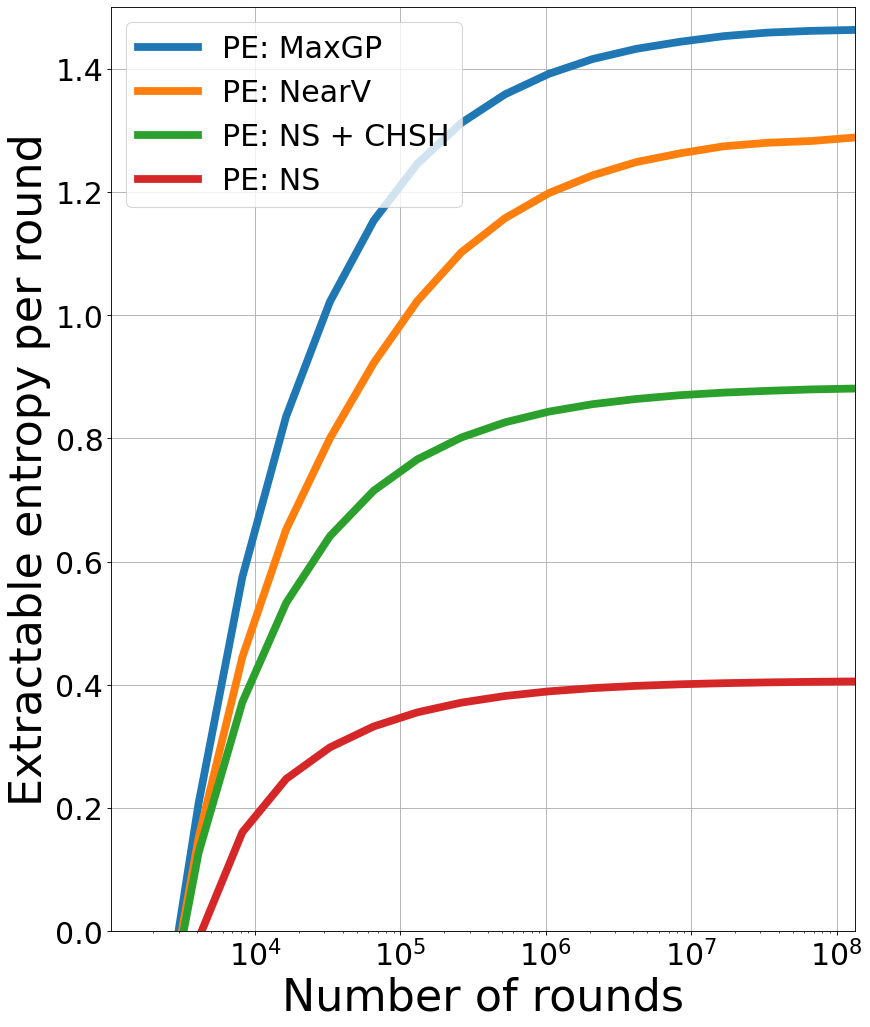

In [11]:
plt.figure(figsize=(12, 15), dpi=80)
plt.rc('font', size=27)

plt.plot(N_list, CHSH_wnd005_EntR_vs_N_MaxGP, linewidth=7)
plt.plot(N_list, CHSH_wnd005_EntR_vs_N_NearV, linewidth=7)
plt.plot(N_list, CHSH_wnd005_EntR_vs_N_NS_CHSH, linewidth=7)
plt.plot(N_list, CHSH_wnd005_EntR_vs_N_NS, linewidth=7)
plt.xscale('log')
plt.xlim([2**10, 2**27])
plt.ylim([0,1.5])
plt.legend(['PE: MaxGP', 'PE: NearV', 'PE: NS + CHSH', 'PE: NS'], prop={'size': 27}, loc=2)
plt.grid()
plt.xlabel('Number of rounds', fontsize=40)
plt.ylabel('Extractable entropy per round', fontsize=40)
plt.show()

### 15% white noise

In [3]:
# Generate quantum correlation
P_in = np.array([[1/4,1/4],[1/4,1/4]]) # Input distribution
P_CHSH_wnd15 = genDistCHSH(0.15) # P_reg - no need for regularisation
E_CHSH_wnd15 = p2E_bi(P_CHSH_wnd15)
print("CHSH value:", -np.einsum('ij,ij->', CHSH_ineq, E_CHSH_wnd15)+2)
sec = 2**(-128)

CHSH value: 2.4041630560342613


In [4]:
### Define the PE_analysis class for CHSH correlation with 15% white noise ###
CHSH_wnd15 = PE_analysis(P_CHSH_wnd15, P_in)

In [5]:
### Generate various polytopes ###
# NS polytope
CHSH_wnd15.generate_Poly('NS')
# NS+CHSH polytope
CHSH_wnd15.generate_Poly('NS+CHSH')
# 10 iterations of NearV algorithm with cutoff=10
CHSH_wnd15.generate_Poly('NearV', niter=10, cutoff=10) 
# 10 iterations of MaxGP algorithm
CHSH_wnd15.generate_Poly('MaxGP', niter=10)

=================== NearV algorithm starts ===================
Iteration 0 starts
Chosen index: 8
---------------------
Iteration 1 starts
Chosen index: 7
---------------------
Iteration 2 starts
Chosen index: 1
---------------------
Iteration 3 starts
Chosen index: 9
---------------------
Iteration 4 starts
Chosen index: 9
---------------------
Iteration 5 starts
MOSEK failed -  too close to the quantum set.
Chosen index: 2
---------------------
Iteration 6 starts
MOSEK failed -  too close to the quantum set.
Chosen index: 1
---------------------
Iteration 7 starts
MOSEK failed -  too close to the quantum set.
Chosen index: 4
---------------------
Iteration 8 starts
MOSEK failed -  too close to the quantum set.
Chosen index: 0
---------------------
Iteration 9 starts
MOSEK failed -  too close to the quantum set.
MOSEK failed -  too close to the quantum set.
MOSEK failed -  too close to the quantum set.
MOSEK failed -  too close to the quantum set.
Chosen index: 7
---------------------

In [6]:
### Opimise PEF for fixed PEF power ###
CHSH_wnd15.max_power = 0.1
first_power = 0.0001
n_points = 151
# NS polytope
CHSH_wnd15.get_optF('NS', first_power=first_power, n_points=n_points)
# NS+CHSH polytope
CHSH_wnd15.get_optF('NS+CHSH', first_power=first_power, n_points=n_points)
# NearV algorithm
CHSH_wnd15.get_optF('NearV', n_list=[9], first_power=first_power, n_points=n_points)
# MaxGP alforithm
CHSH_wnd15.get_optF('MaxGP', n_list=[9], first_power=first_power, n_points=n_points)

=================== Optimise PEF for 'NS' ===================


100%|█████████████████████████████████████████| 151/151 [00:13<00:00, 11.38it/s]


=================== Optimise PEF for 'NS+CHSH' ===================


100%|█████████████████████████████████████████| 151/151 [00:15<00:00,  9.63it/s]


=================== Optimise PEF for 'NearV' ===================


100%|█████████████████████████████████████████| 151/151 [04:20<00:00,  1.72s/it]


=================== Optimise PEF for 'MaxGP' ===================


100%|█████████████████████████████████████████| 151/151 [16:38<00:00,  6.62s/it]


In [7]:
### Analyse with different N
N_list = [2**n for n in range(10,28)]

CHSH_wnd15_EntR_vs_N_NS = []
CHSH_wnd15_EntR_vs_N_NS_CHSH = []
CHSH_wnd15_EntR_vs_N_NearV = []
CHSH_wnd15_EntR_vs_N_MaxGP = []

for N in N_list:
    ## Generate artificial data
    N_raw = np.reshape([N*P_CHSH_wnd15[a,b,x,y]*P_in[x,y] for a,b,x,y in it.product(range(2),repeat=4)], (2,2,2,2))
    
    # 'NS'
    NS = CHSH_wnd15.randomness_accumulation(N_raw, sec, 'NS', n_list=[0])
    CHSH_wnd15_EntR_vs_N_NS.append(NS[0]['entropy rate'])
    
    # 'NS+CHSH'
    NS_CHSH = CHSH_wnd15.randomness_accumulation(N_raw, sec, 'NS+CHSH', n_list=[0])
    CHSH_wnd15_EntR_vs_N_NS_CHSH.append(NS_CHSH[0]['entropy rate'])
    
    # 'NearV'
    NearV = CHSH_wnd15.randomness_accumulation(N_raw, sec, 'NearV', n_list=[9])
    CHSH_wnd15_EntR_vs_N_NearV.append(NearV[0]['entropy rate'])
    
    # 'NS'
    MaxGP = CHSH_wnd15.randomness_accumulation(N_raw, sec, 'MaxGP', n_list=[9])
    CHSH_wnd15_EntR_vs_N_MaxGP.append(MaxGP[0]['entropy rate'])

In [14]:
# with open('CHSH_wnd15.pkl', 'wb') as outp:
#     pickle.dump(CHSH_wnd15, outp, pickle.HIGHEST_PROTOCOL)
    
# with open('CHSH_wnd15.pkl', 'rb') as inp:
#     CHSH_wnd15 = pickle.load(inp)

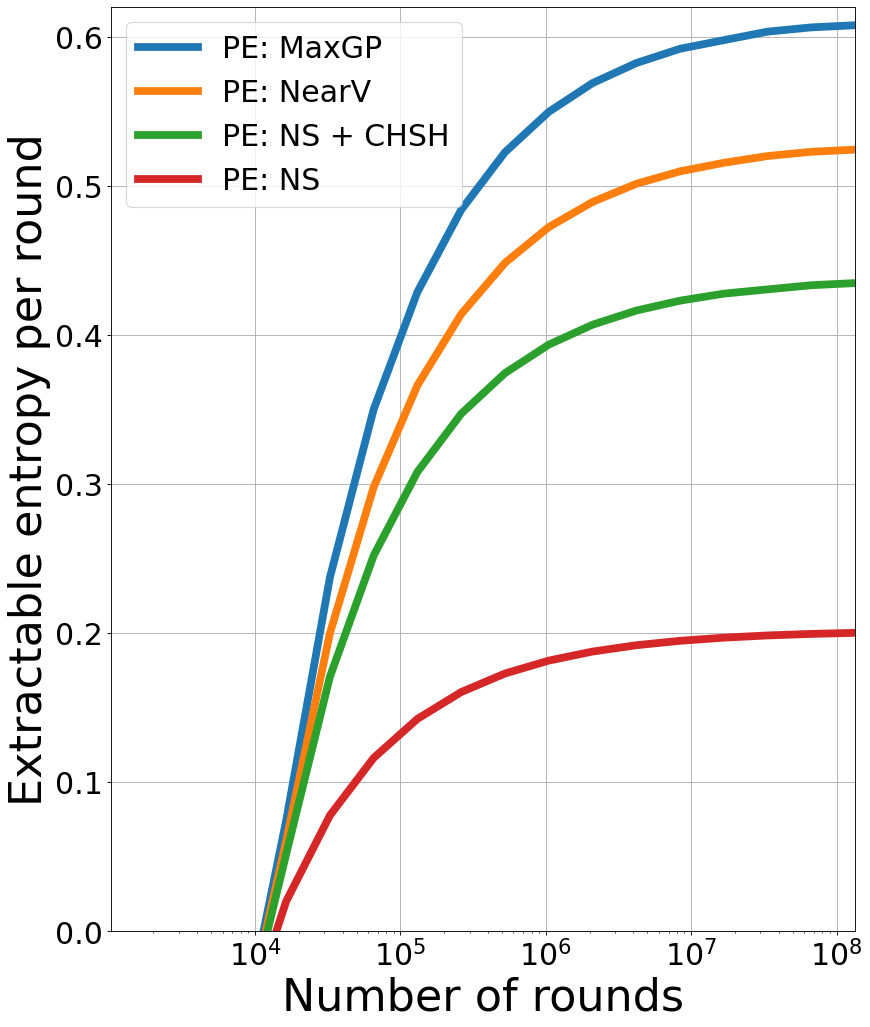

In [9]:
plt.figure(figsize=(12, 15), dpi=80)
plt.rc('font', size=27)

plt.plot(N_list, CHSH_wnd15_EntR_vs_N_MaxGP, linewidth=7)
plt.plot(N_list, CHSH_wnd15_EntR_vs_N_NearV, linewidth=7)
plt.plot(N_list, CHSH_wnd15_EntR_vs_N_NS_CHSH, linewidth=7)
plt.plot(N_list, CHSH_wnd15_EntR_vs_N_NS, linewidth=7)
plt.xscale('log')
plt.xlim([2**10, 2**27])
plt.ylim([0,0.62])
plt.legend(['PE: MaxGP', 'PE: NearV', 'PE: NS + CHSH', 'PE: NS'], prop={'size': 27}, loc=2)
plt.grid()
plt.xlabel('Number of rounds', fontsize=40)
plt.ylabel('Extractable entropy per round', fontsize=40)
plt.show()

### 25% white noise

In [3]:
# Generate quantum correlation
P_in = np.array([[1/4,1/4],[1/4,1/4]]) # Input distribution
P_CHSH_wnd25 = genDistCHSH(0.25) # P_reg - no need for regularisation
E_CHSH_wnd25 = p2E_bi(P_CHSH_wnd25)
print("CHSH value:", -np.einsum('ij,ij->', CHSH_ineq, E_CHSH_wnd25)+2)
sec = 2**(-128)

CHSH value: 2.121320343559642


In [4]:
### Define the PE_analysis class for CHSH correlation with 25% white noise ###
CHSH_wnd25 = PE_analysis(P_CHSH_wnd25, P_in)

In [5]:
### Generate various polytopes ###
# NS polytope
CHSH_wnd25.generate_Poly('NS')
# NS+CHSH polytope
CHSH_wnd25.generate_Poly('NS+CHSH')
# 10 iterations of NearV algorithm with cutoff=10
CHSH_wnd25.generate_Poly('NearV', niter=10, cutoff=10) 
# 10 iterations of MaxGP algorithm
CHSH_wnd25.generate_Poly('MaxGP', niter=10)

=================== NearV algorithm starts ===================
Iteration 0 starts
Chosen index: 7
---------------------
Iteration 1 starts
Chosen index: 1
---------------------
Iteration 2 starts
Chosen index: 5
---------------------
Iteration 3 starts
Chosen index: 2
---------------------
Iteration 4 starts
Chosen index: 4
---------------------
Iteration 5 starts
Chosen index: 0
---------------------
Iteration 6 starts
Chosen index: 2
---------------------
Iteration 7 starts
Chosen index: 7
---------------------
Iteration 8 starts
Chosen index: 8
---------------------
Iteration 9 starts
Chosen index: 4
---------------------
=================== MaxGP algorithm starts ===================
Iteration 0 starts
Chosen input for guessing probability: 1 1
Generating the polytope for optimal solution no.1...
Optimal solution no.1 is quantum. Continue to the next one.
Generating the polytope for optimal solution no.2...
Generating the polytope for optimal solution no.3...
Generating the polytope

In [6]:
### Opimise PEF for fixed PEF power ###
CHSH_wnd25.max_power = 0.1
first_power = 0.0001
n_points = 151
# NS polytope
CHSH_wnd25.get_optF('NS', first_power=first_power, n_points=n_points)
# NS+CHSH polytope
CHSH_wnd25.get_optF('NS+CHSH', first_power=first_power, n_points=n_points)
# NearV algorithm
CHSH_wnd25.get_optF('NearV', n_list=[9], first_power=first_power, n_points=n_points)
# MaxGP alforithm
CHSH_wnd25.get_optF('MaxGP', n_list=[9], first_power=first_power, n_points=n_points)

=================== Optimise PEF for 'NS' ===================


100%|█████████████████████████████████████████| 151/151 [00:13<00:00, 11.45it/s]


=================== Optimise PEF for 'NS+CHSH' ===================


100%|█████████████████████████████████████████| 151/151 [00:15<00:00,  9.60it/s]


=================== Optimise PEF for 'NearV' ===================


100%|█████████████████████████████████████████| 151/151 [06:12<00:00,  2.47s/it]


=================== Optimise PEF for 'MaxGP' ===================


100%|█████████████████████████████████████████| 151/151 [11:53<00:00,  4.73s/it]


In [7]:
### Analyse with different N
N_list = [2**n for n in range(10,28)]

CHSH_wnd25_EntR_vs_N_NS = []
CHSH_wnd25_EntR_vs_N_NS_CHSH = []
CHSH_wnd25_EntR_vs_N_NearV = []
CHSH_wnd25_EntR_vs_N_MaxGP = []

for N in N_list:
    ## Generate artificial data
    N_raw = np.reshape([N*P_CHSH_wnd25[a,b,x,y]*P_in[x,y] for a,b,x,y in it.product(range(2),repeat=4)], (2,2,2,2))
    
    # 'NS'
    NS = CHSH_wnd25.randomness_accumulation(N_raw, sec, 'NS', n_list=[0])
    CHSH_wnd25_EntR_vs_N_NS.append(NS[0]['entropy rate'])
    
    # 'NS+CHSH'
    NS_CHSH = CHSH_wnd25.randomness_accumulation(N_raw, sec, 'NS+CHSH', n_list=[0])
    CHSH_wnd25_EntR_vs_N_NS_CHSH.append(NS_CHSH[0]['entropy rate'])
    
    # 'NearV'
    NearV = CHSH_wnd25.randomness_accumulation(N_raw, sec, 'NearV', n_list=[9])
    CHSH_wnd25_EntR_vs_N_NearV.append(NearV[0]['entropy rate'])
    
    # 'MaxGP'
    MaxGP = CHSH_wnd25.randomness_accumulation(N_raw, sec, 'MaxGP', n_list=[9])
    CHSH_wnd25_EntR_vs_N_MaxGP.append(MaxGP[0]['entropy rate'])

In [17]:
# with open('CHSH_wnd25.pkl', 'wb') as outp:
#     pickle.dump(CHSH_wnd25, outp, pickle.HIGHEST_PROTOCOL)
    
# with open('CHSH_wnd25.pkl', 'rb') as inp:
#     CHSH_wnd25 = pickle.load(inp)

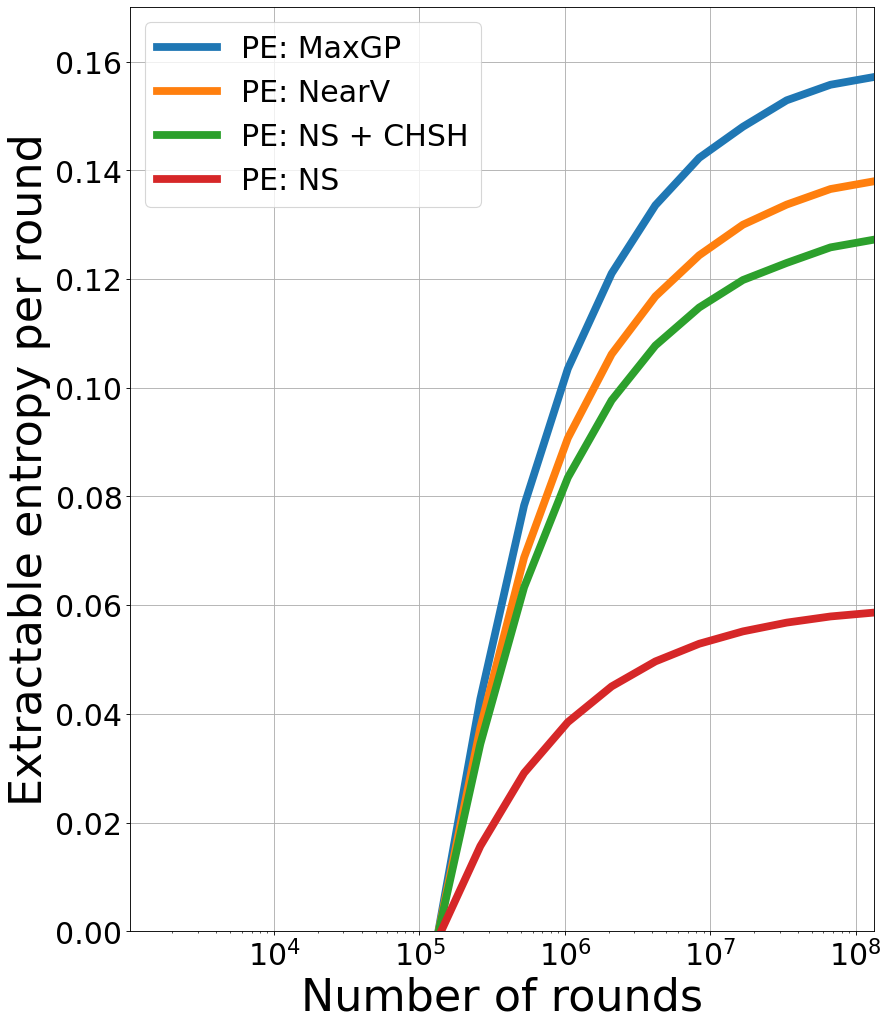

In [8]:
plt.figure(figsize=(12, 15), dpi=80)
plt.rc('font', size=27)

plt.plot(N_list, CHSH_wnd25_EntR_vs_N_MaxGP, linewidth=7)
plt.plot(N_list, CHSH_wnd25_EntR_vs_N_NearV, linewidth=7)
plt.plot(N_list, CHSH_wnd25_EntR_vs_N_NS_CHSH, linewidth=7)
plt.plot(N_list, CHSH_wnd25_EntR_vs_N_NS, linewidth=7)
plt.xscale('log')
plt.xlim([2**10, 2**27])
plt.ylim([0,0.17])
plt.legend(['PE: MaxGP', 'PE: NearV', 'PE: NS + CHSH', 'PE: NS'], prop={'size': 27}, loc=2)
plt.grid()
plt.xlabel('Number of rounds', fontsize=40)
plt.ylabel('Extractable entropy per round', fontsize=40)
plt.show()